# Spatial As Deep: Spatial CNN for Traffic Scene Understanding

## 车道线检测存在问题

现今的CNN模型通常是由卷积块堆叠构建，虽然CNN有强大的特征提取能力，但现存CNN架构没有足够充分探索图像行和列上的空间关系能力。这些关系对于学习强先验形状的对象很重要，尤其是外观(图像像素)连贯性很弱。例如交通线，车道经常会被遮挡，或者压根就没在路上画车道线。如下图所示：
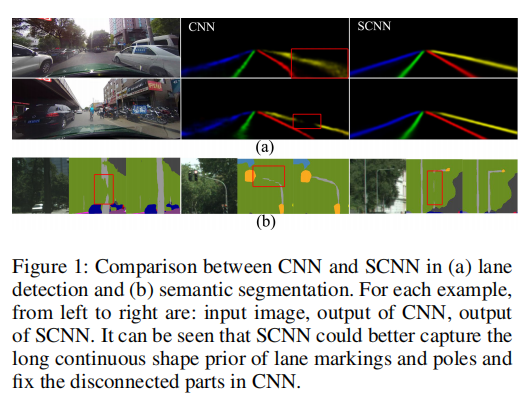


## scnn优点缺点

### 优点
本文提出了Spatial CNN(CNN),它将传统的卷积层接层(layer-by-layer)的连接形式的转为feature map中片连片卷积(slice-by-slice)的形式，使得图中像素行和列之间能够传递信息。这特别适用于检测长距离连续形状的目标或大型目标，有着极强的空间关系但是外观线索较差的目标，例如交通线，电线杆和墙。论文在车道检测挑战和CityScapes上评估了SCNN的表现，同时SCNN在TuSimple Benchmark lane Detection challenge获得了第一名，准确率为96.53%。

## scnn亮点

## scnn详细解读

### Introduction
　　自动驾驶中**最具挑战的任务之一是交通场景理解**，包括计算机视觉任务下的**车道检测**和**语义分割**。**车道检测帮助指导车辆**，**语义分割提供更多关于周围环境目标的细节位置**。但在实际情况下，因为有许多恶劣条件，这些任务可能非常具有挑战性。对于交通场景理解的另一个挑战是，在许多情况下需要在有**强结构先验知识**下处理外形线索不多的目标，例如交通线，杆状物等，这些具有长距离连续的形状，常常有很大部分被**遮挡**。

　　得益于强大的学习表示能力，CNN将视觉理解推向了一个新的高度。但是这依然不能很好地处理外形线索不多的有强结构先验的目标，而人类可以推断它们的位置并填充遮挡的部分。

　　为了解决这个问题，论文提出了SCNN，将深度卷积神经网络推广到丰富空间层次。

　　传统的CNN，任意层接收上层的数据作输入，再作卷积并加激活传给下一层，这个过程是顺序执行的。与之类似的是，SCNN将feature map的行或列也看成layer，也使用卷积加非线性激活，从而实现空间上的深度神经网络。这使得空间信息能够在同层的神经元上传播，增强空间信息进而对于识别结构化对象特别有效。

相关工作：

　　对于车道检测任务，大多数现有的算法都是依赖于低级手工特征，这让模型难以在恶劣条件下工作。2015年有工作尝试使用深度学习方案用于车道检测，但苦于没有大的广泛的数据集(说这个的原因是论文建立了一个大的数据集~)。对于语义分割，基于CNN的方案的已经成为主流并取得了巨大的成功。

　　对于在深度神经网络中使用空间信息：有工作使用**RNN按每列和行传递信息，但每个像素只能接收同一行或列的信息**。也有工作**使用LSTM变体探索语义分割的上下文信息，但计算消耗较大**。也有工作**尝试结合CNN和图模型(例如MRF或CRF)，通过大卷积核传递信息**。

与上述方案相比，SCNN有如下几个**优势**：

> **<1>消息传递比传统的MRF/CRF更有计算效率**
>
> **<2>消息传递使用的是残差，这更易训练**
>
> **<3>SCNN很灵活，适用于多种深度神经网络**

### Spatial Convolutional Neural Network
**Lane Detection Dataset**
　　本文提出了一个关于交通车道检测的大规模数据集。**以前的车道检测数据集(KITTI,CamVid)要不就是太简单，要不就是数据太小**。最近的(**Caltech**,**TuSimple**)数据集是在交通受限状态下建立的，这样的数据**车流量少且路标较为清晰**。这些数据集**没有包括一些车道线模糊，条件恶劣的情况**，而这些情况人类可以推断出来，且这具有很高的实用价值。

　　**论文提出的数据集是由六辆车在北京不同时间录制的，超过55个小时共收集了133,235 张图片，这超过TuSimple 数据集20倍了。论文分成88880张作为训练集, 9675作为验证集，34680做测试集。图像的大小为**
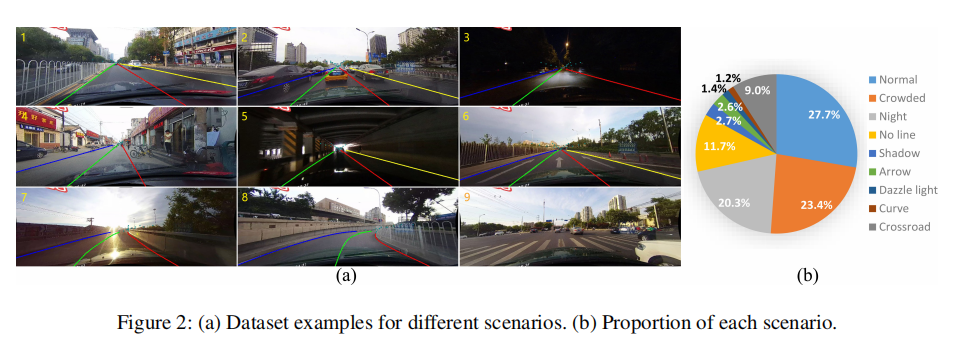

　　**数据集内包括城市、农村和高速公路等场景，北京作为世界上最大和最拥挤的城市之一，对应的车道检测数据提供了很多具有挑战性的交通场景。论文将测试集分为正常和8个具有挑战性的类别，这对应上图 (a)的9个示例情况。图(b)显示的是挑战性的场景站数据集的比例(共72.3%)。**

　　**对于每一张图片，使用三条线注释车道**，如前面所述，许多情况下车道是被遮挡的或看不见的。而这在实际情况下是很重要的，车道检测算法需要能够在这种情况下工作。对此，标注工作根据上下文也做了标注，如图(2)(4)所示。对于图(1)的情况我们不对障碍的另一边做标注，将精力集中于最受关注的部分。

### Spatial CNN
　　传统的关于空间关系的建模方法是**基于概率图模型**的，例如**马尔科夫随机场(MRF)**或**条件随机场(CRF)**。最近有工作**将概率图与CNN相结合**，如图 3(a)所示：
  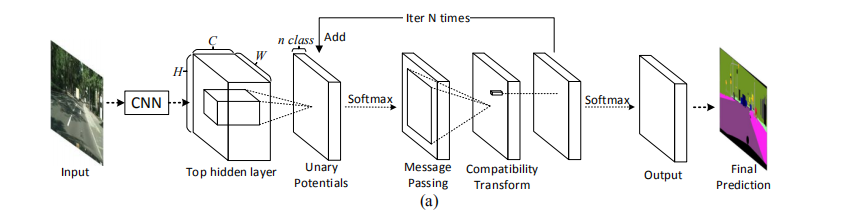
  **CRF可化为平均场，算法可以用神经网络来实现**，具体来说，过程分为：

> 标准化：CNN的输出作为一元势函数，并通过Softmax操作标准化
> 信息传递：可通过大内核的逐通道卷积实现(对于DenseCRF,内核大小将覆盖整张图片，内核权重取决于图片)
> 兼容性转换：使用
> 添加一元势：整个过程迭代N次得到最终输出
　　可以看到传统方法在传递信息时，每个像素点接受来自全图其他像素的信息，这在计算上是非常昂贵的，难以应用于实时系统。且对于MRF的大卷积核权重很难学。这些方法是应用在CNN的输出上的，论文认为CNN的隐藏层，包含了丰富的空间关系，可更好的用于处理空间关系。

　　论文提出了Spatial CNN，这里的**Spatial不是指Spatial Convolution**，**而是CNN通过特征的设计架构传递空间信息**。**SCNN更有效的学习空间关系，能平滑的找出连续的有强先验的结构目标**。SCNN的整体架构如下：

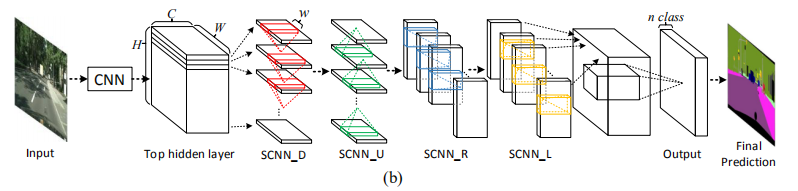

图中SCNN的下标有**D,U,R,L**，这在结构上是类似的，**方向上分别表示为向下，向上，向右，向左**

先以SCNN_D分析：

　　考虑到SCNN应用在三维张量C×H×W, 具体来讲，假设我们有一个三维的张量K
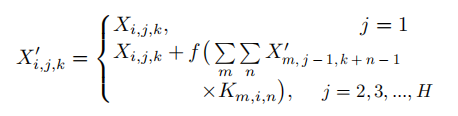

### Analysis
SCNN相比于传统方法，有三个优势：

1. 计算效率
　　SCNN与传统的Dense MRF/CRF相比，在信息传递方向不同，示意图如下所示：
  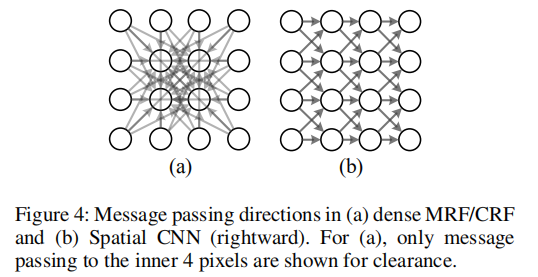
  > 图(a)：MRF/CRF中每个像素点会直接接收其他所有像素点的信息(大卷积核实现)，这其中有许多冗余计算。
  >
  > 图(b)：在SCNN中，信息是顺序传递的。

2. 将传递信息作残差
　　**密集的MRF/CRF内是通过所有加权像素相加**，这样的**计算花费很大**。而**RNN是通过梯度来优化的**， 考虑到这么多层和列，依据残差网络的经验，论文也采用残差的方式来学习(计算公式描述的残差学习)。这种残差可认为是对原始神经元的修正。实验证明这样的消息传递比基于LSTM的要好。

3. 灵活性
　　归功于SCNN的计算效率，它**可以很方便的集成到CNN的任何部分**。**通常 top hidden layer 包含了丰富的语义信息，这是应用SCNN的理想位置**。在完整的SCNN模型中我们在顶层的 feature map上用了四个方向的SCNN引入空间信息传递。



## Experiment
　　论文在自发布的**lane detection dataset** 和 **CityScapes**数据集做了评估。 
　　采用标准的SGD训练器，学习率采用”poly”策略，初始学习率为0.01，power为0.9。batchsize设置为12，动量为0.9，权重衰减为0.0001。迭代次数为60K。模型架构在LargeFOV(DeepLabv2)基础上修改，初始的13层采用的是在ImageNet上预训练的VGG16层。所有的实验使用的工作是Torch7.

### Lane Detection
　　普通的目标识别只要划分边界,而车道检测需要精准的预测曲线，一个自然的想法是模型输出曲线的概率图，以像素级目标来训练网络，这类似于语义分割任务。我们希望网络能够直接区分不同车道标记，这样鲁棒性更好。**共有4中类型的车道线???**。**输出的概率图经过一个小网络预测车道标记是否存在**。

　　在测试期间，同样需要从概率图转为曲线，模型大致示意如下图(b)所示：
  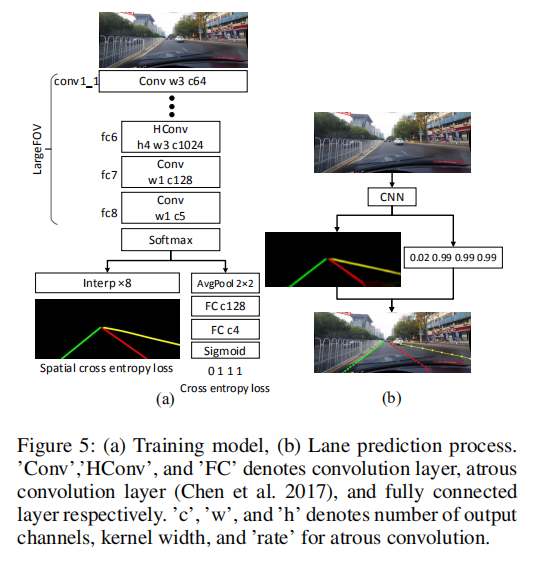
  对于存在值大于0.5的车道标记，在对应的概率图每20行搜索以获得最高的响应位置，然后通过三次样条函数连接这些点(cubic splines)。这就是最终的预测。

上图(a)显示了baseline和LargeFOV之间的差异：
1. fc7输出通道为128
2. fc6扩张卷积的扩张率为4
3. 每个ReLU层前加了BN层
4. 添加了一个小型网络用于预测是否存在车道线
　训练时，输入和输出的图片分辨率设置为800×288

### 评估
　　**为了判断车道标记是否正确的检测到**，论文**将车道标记视为宽度为30像素的线**，计算ground truth和预测值之间的IoU.如果预测的IoU大于某个阈值，则认为是true positives (TP). 如下图6所示，这里设置了0.3和0.5作为阈值，分别对应松散和严格的评估。
  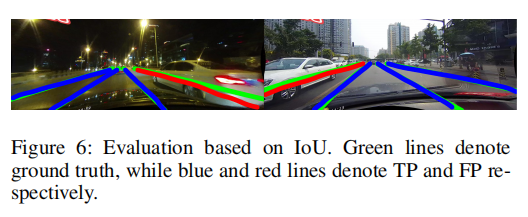
  然后使用
  F−measure = 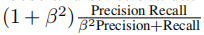

### Ablation Study
================================================

Ablation study 消融实验，在计算机视觉领域中，往往提及消融实验来验证本文的创新点。

比如你弄了个目标检测的pipeline用了A, B, C，然后效果还不错，但你并不知道A, B, C各自到底起了多大的作用，可能B效率很低同时精度很好，也可能A和B彼此相互促进。
Ablation study/experiment就是用来告诉你或者读者整个流程里面的关键部分到底起了多大作用，就像Ross将RPN换成SS进行对比实验，以及与不共享主干网络进行对比，就是为了给读者更直观的数据来说明算法的有效性。

在原理上有些像控制变量法。

================================================

1. Effectiveness of multidirectional SCNN
首先探究了**SCNN里信息传递方向的有效性**。对比实验如下表：
    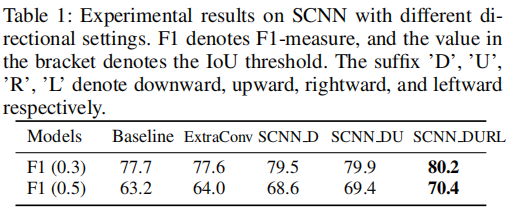
**SCNN的核宽度w=5**
2. Effects of kernel width w
　　论文在SCNN_DURL的基础上测试了不同核宽度对性能的影响，核宽度表示像素可以接收其他像素的信息数量，结果如下
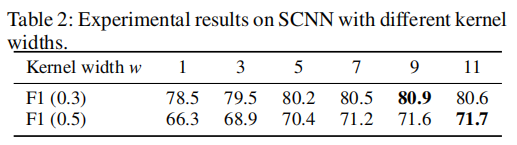
3. Spatial CNN on different positions
　　**SCNN可以添加到模型的任何地方**，在图3中，将SCNN_DURL应用于output上或top hidden layer：
  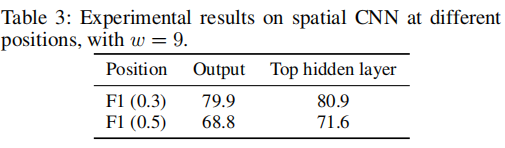
  可以看到放置在top hidden layer后效果要出色，这是因为top hidden layer包含更丰富的信息。
4. Effectiveness of sequential propagation
　　在SCNN中，**信息时连续方式传递的**，**SCNN的一片不会传递信息给下一片，直到它接收到别的片传来的信息(???)**。与此做对比的时，使用平行策略(parallel)，即每个片在更新前将信息传递给一下片，一起更新，结果如下：
  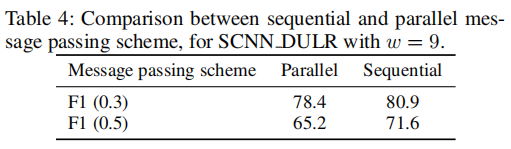
可以看到顺序传递的优势较大，这表明在SCNN中，像素不仅受到邻近像素的影响，也受到更远距离的像素影响。
5. Comparison with state-of-the-art methods
论文将SCNN与几个先进模型对比结果如下：
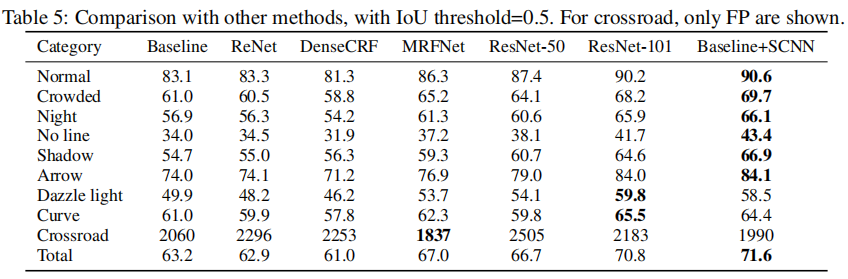
基于LSTM的Renet：使用两个ReNet层替换Figure 3中SCNN层
+ DenseCRF：采用了10个平均场迭代
+ MRFNet：使用Figure 3(a)，迭代10次，内核大小为20
+ ResNet：基于与DeepLabv2相同，除了不使用ASPP模块
可以看到SCNN的效果很出色~

可视化结果如下：
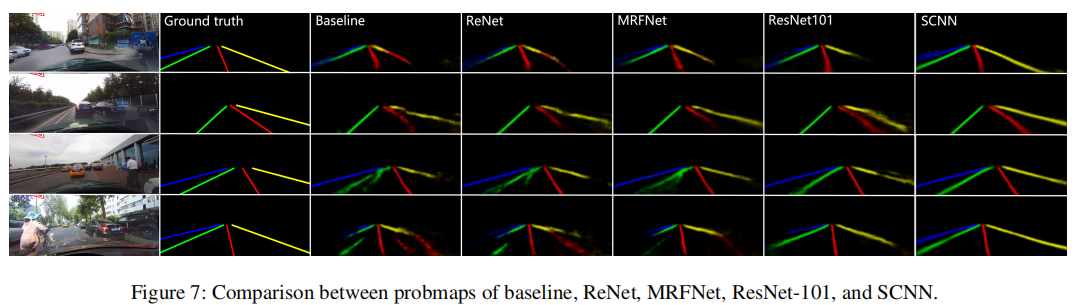
可以看到SCNN要比大型的ResNet101要好，虽然ResNet101参数多，但是在这种具有挑战性的情况下会产生杂乱或不连续的输出，SCNN相比能够保持平滑性。这表明SCNN相比于传统CNN能够更好的捕捉强先验结构的目标。
6. Computational efficiency over other methods
同时论文给出了与其他模型时间效率上的对比。注意计算时间没有包括网络主干。都是在CPU上跑的。
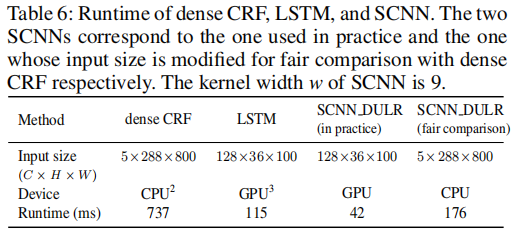
可以看到SCNN比CRF要快很多，这是因为传递信息策略的改变。

## Semantic Segmentation on CityScapes
论文同时也在CityScapes上做了测试，使用DeepLabv2的LargeFOV和ResNet101作为baseline，在LargeFOV上添加BN层，对于两个模型，top hidden layer的通道数改为128.
配置SCNN的是SCNN_DURL在w=9
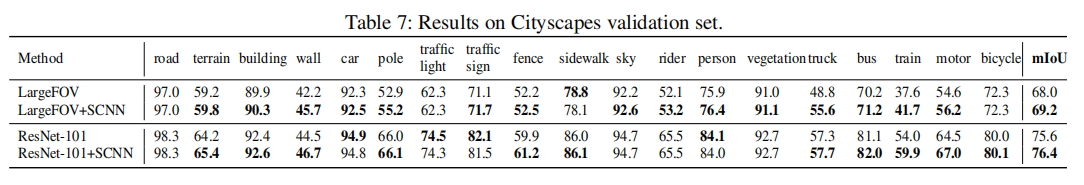
可以看到配置了SCNN的模型，在墙、杆等类别有着显著的提升，这是因为SCNN能够捕捉这些长距离连续物体。

可视化结果如下：
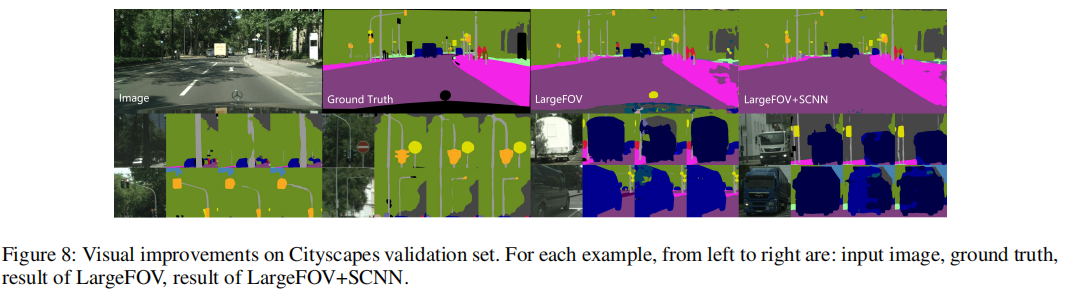
有一个有意思的地方，汽车的底部在训练期间是不做标记的，在LargeFOV上是缺失的，因为SCNN的信息传递，被分类成道路。

论文也将SCNN方法与其他方法做了对比，也使用了VGG16为网络主干，结果如下：
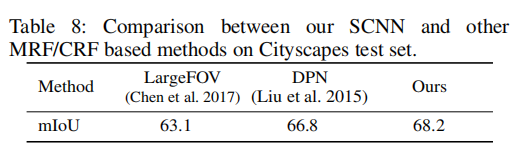

## Conclusion
论文提出了Spatial CNN，在空间层上实现信息的有效传递。SCNN易于融入到其他深度神经网络中做end-2-end训练。论文在车道检测和语义分割上测试了SCNN，结果表现SCNN可以有效的保持长距离连续结构，在语义分割其扩散效应对识别大型物体有利。

　　此外，论文提出了一个车道检测的数据集，希望能够推动自动驾驶进一步发展。

